# Анализ лояльности пользователей Яндекс Афиши

**Описание задачи**

Команда маркетинга поставила перед собой цель: не просто привлекать новых пользователей, а удерживать их и превращать в постоянных.

Для этого нужно повысить долю клиентов, которые после одной покупки приходят снова и совершают новые.

Нужно помочь команде маркетинга лучше понять поведение пользователей. 

Для этого необходимо провести исследовательский анализ данных, чтобы выяснить, какие пользователи с большей вероятностью возвращаются на платформу и делают заказы повторно. 

Это позволит:
 - Быстро выявлять перспективных клиентов и предлагать им персонализированные условия.
 - Точно настраивать рекламу на аудитории с высокой вероятностью возврата.
 - Оптимизировать маркетинговые бюджеты.
 - Повысить общий уровень удержания клиентов.

## Этапы выполнения проекта

### 1. Загрузка данных и их предобработка

---

**Задача 1.1:** Напишите SQL-запрос, выгружающий в датафрейм pandas необходимые данные. Используйте следующие параметры для подключения к базе данных `data-analyst-afisha`:

- **Хост** — `rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net`
- **База данных** — `data-analyst-afisha`
- **Порт** — `6432`
- **Аутентификация** — `Database Native`
- **Пользователь** — `praktikum_student`
- **Пароль** — `Sdf4$2;d-d30pp`

Для выгрузки используйте запрос из предыдущего урока и библиотеку SQLAlchemy.

Выгрузка из базы данных SQL должна позволить собрать следующие данные:

- `user_id` — уникальный идентификатор пользователя, совершившего заказ;
- `device_type_canonical` — тип устройства, с которого был оформлен заказ (`mobile` — мобильные устройства, `desktop` — стационарные);
- `order_id` — уникальный идентификатор заказа;
- `order_dt` — дата создания заказа (используйте данные `created_dt_msk`);
- `order_ts` — дата и время создания заказа (используйте данные `created_ts_msk`);
- `currency_code` — валюта оплаты;
- `revenue` — выручка от заказа;
- `tickets_count` — количество купленных билетов;
- `days_since_prev` — количество дней от предыдущей покупки пользователя, для пользователей с одной покупкой — значение пропущено;
- `event_id` — уникальный идентификатор мероприятия;
- `service_name` — название билетного оператора;
- `event_type_main` — основной тип мероприятия (театральная постановка, концерт и так далее);
- `region_name` — название региона, в котором прошло мероприятие;
- `city_name` — название города, в котором прошло мероприятие.

---


In [1]:
# Используйте ячейки типа Code для вашего кода,
# а ячейки типа Markdown для комментариев и выводов

In [2]:
# При необходимости добавляйте новые ячейки для кода или текста

Загружаем и устанавливаем библиотеки

In [3]:
!pip install sqlalchemy

In [4]:
!pip install psycopg2

  Using cached psycopg2-2.9.11.tar.gz (379 kB)
    ERROR: Command errored out with exit status 1:
     command: /opt/conda/bin/python3.9 -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-4cfp5oi0/psycopg2_64b85df6f7a24467a20f8876c142bf60/setup.py'"'"'; __file__='"'"'/tmp/pip-install-4cfp5oi0/psycopg2_64b85df6f7a24467a20f8876c142bf60/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' egg_info --egg-base /tmp/pip-pip-egg-info-65arfz16
         cwd: /tmp/pip-install-4cfp5oi0/psycopg2_64b85df6f7a24467a20f8876c142bf60/
    Complete output (23 lines):
    running egg_info
    creating /tmp/pip-pip-egg-info-65arfz16/psycopg2.egg-info
    writing /tmp/pip-pip-egg-info-65arfz16/psycopg2.egg-info/PKG-INFO
    writing dependency_links to /tmp/pip-

In [5]:
!pip install psycopg2-binary

In [6]:
import pandas as pd
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

!pip install phik
from phik import phik_matrix 

Подключаемся к базе данных

In [7]:
db_config = {'user': 'praktikum_student', # имя пользователя
             'pwd': 'Sdf4$2;d-d30pp', # пароль
             'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
             'port': 6432, # порт подключения
             'db': 'data-analyst-afisha' # название базы данных
             }

In [8]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [9]:
engine = create_engine(connection_string)

Создаем SQL запрос для выгрузки данных

In [10]:
query = '''
SELECT
    user_id,
    device_type_canonical,
    order_id,
    created_dt_msk,
    created_ts_msk,
    currency_code,
    revenue,
    tickets_count,
    created_dt_msk::date - LAG(created_dt_msk::date) OVER(PARTITION BY user_id ORDER BY created_dt_msk) AS days_since_prev,
    p.event_id,
    event_name_code AS event_name,
    event_type_main,
    service_name,
    region_name,
    city_name
FROM
    afisha.purchases AS p 
LEFT JOIN
    afisha.events AS e 
ON
    p.event_id = e.event_id
LEFT JOIN
    afisha.city AS c 
ON
    e.city_id = c.city_id
LEFT JOIN
    afisha.regions AS r 
ON
    c.region_id = r.region_id
WHERE
    device_type_canonical IN ('mobile', 'desktop')
    AND event_type_main != 'фильм'
ORDER BY
    user_id
'''

Создаем датафрейм на основе выгруженных данных

In [11]:
df = pd.read_sql_query(query, con=engine)

---

**Задача 1.2:** Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных.

Предположите, какие шаги необходимо сделать на стадии предобработки данных — например, скорректировать типы данных.

Зафиксируйте основную информацию о данных в кратком промежуточном выводе.

---

In [12]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк


In [13]:
# создаем копию датасета до преобразования для возможности проверить сделанные изменения после предобработки
temp = df.copy() 
len(temp)

290611

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [15]:
df.describe()

,order_id,revenue,tickets_count,days_since_prev,event_id
count,2.906110e+05,290611.000000,290611.000000,268678.000000,290611.000000
mean,4.326225e+06,625.584360,2.754311,3.222381,438019.834992
std,2.497551e+06,1227.693064,1.170620,11.350509,147423.078841
min,1.000000e+00,-90.760000,1.000000,0.000000,4436.000000
25%,2.163618e+06,116.850000,2.000000,0.000000,361772.000000
50%,4.326366e+06,356.010000,3.000000,0.000000,498275.000000
75%,6.488330e+06,810.130000,4.000000,1.000000,546287.000000
max,8.653108e+06,81174.540000,57.000000,148.000000,592325.000000


Данные выгружены корректно, пропуски присутствубт только в поле `days_since_prev`, как и ожидалось. Всего в полученном датафрейме 15 столбцов и 290611 строк. Типы данных для соответствующих колонок указаны верно, однако в качестве предобработки можно понизить разрядности типов `int64` и `float64` до минимально необходимых.

---

###  2. Предобработка данных

Выполните все стандартные действия по предобработке данных:

---

**Задача 2.1:** Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

Для этого используйте датасет с информацией о курсе казахстанского тенге по отношению к российскому рублю за 2024 год — `final_tickets_tenge_df.csv`. Его можно загрузить по пути `https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')`

Значения в рублях представлено для 100 тенге.

Результаты преобразования сохраните в новый столбец `revenue_rub`.

---


In [16]:
final_tickets_tenge_df = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [17]:
final_tickets_tenge_df.head()

,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [18]:
final_tickets_tenge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 357 entries, 0 to 356
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   data     357 non-null    object 
 1   nominal  357 non-null    int64  
 2   curs     357 non-null    float64
 3   cdx      357 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 11.3+ KB


In [19]:
final_tickets_tenge_df['data'] = pd.to_datetime(final_tickets_tenge_df['data'])

In [20]:
merged_df = pd.merge(df, final_tickets_tenge_df, left_on='created_dt_msk', right_on='data', how='left')
merged_df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,data,nominal,curs,cdx
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,2024-08-20,100,18.6972,kzt
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,2024-07-23,100,18.3419,kzt
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,2024-10-06,100,19.6475,kzt
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,2024-07-13,100,18.5010,kzt
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,2024-10-04,100,19.6648,kzt


In [21]:
def converter(row):
    if row['currency_code'] == 'kzt':
        row['revenue_rub'] = row['revenue'] / row['nominal'] * row['curs']
    else:
        row['revenue_rub'] = row['revenue']
    return row

In [22]:
merged_df = merged_df.apply(converter, axis=1)

In [23]:
df['revenue_rub'] = merged_df['revenue_rub']

In [24]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.94
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.45
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.57
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.49
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.41


---

**Задача 2.2:**

- Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце `days_since_prev`.
- Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
- Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.
    - Проверьте, какие категории указаны в столбцах с номинальными данными. Есть ли среди категорий такие, что обозначают пропуски в данных или отсутствие информации? Проведите нормализацию данных, если это необходимо.
    - Проверьте распределение численных данных и наличие в них выбросов. Для этого используйте статистические показатели, гистограммы распределения значений или диаграммы размаха.
        
        Важные показатели в рамках поставленной задачи — это выручка с заказа (`revenue_rub`) и количество билетов в заказе (`tickets_count`), поэтому в первую очередь проверьте данные в этих столбцах.
        
        Если обнаружите выбросы в поле `revenue_rub`, то отфильтруйте значения по 99 перцентилю.

После предобработки проверьте, были ли отфильтрованы данные. Если были, то оцените, в каком объёме. Сформулируйте промежуточный вывод, зафиксировав основные действия и описания новых столбцов.

---

In [25]:
#Проверяем ещё раз на пропуски
df.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
created_dt_msk               0
created_ts_msk               0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
region_name                  0
city_name                    0
revenue_rub                  0
dtype: int64

Ещё раз убедились в том, что пропуски есть только в поле `days_since_prev`.

In [26]:
#Преобразуем типы данных int
for column in ['order_id', 'tickets_count', 'event_id']:
    df[column] = pd.to_numeric(df[column], downcast='integer')

In [27]:
#Преобразуем типы данных float
for column in ['revenue', 'days_since_prev', 'revenue_rub']:
    df[column] = pd.to_numeric(df[column], downcast='float')

Столбцы с датой нет необходимости преобразовывать, т.к. к уменьшению занимаемого места в памяти это не приведет.

In [28]:
#Проверяем
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int32         
 3   created_dt_msk         290611 non-null  datetime64[ns]
 4   created_ts_msk         290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float32       
 7   tickets_count          290611 non-null  int8          
 8   days_since_prev        268678 non-null  float32       
 9   event_id               290611 non-null  int32         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

In [29]:
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.939941,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Каменевский регион,Глиногорск,1521.939941
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.450012,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Каменевский регион,Глиногорск,289.450012
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.569946,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Каменевский регион,Глиногорск,1258.569946
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.490000,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Североярская область,Озёрск,8.490000
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.410034,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Озернинский край,Родниковецк,1390.410034


In [30]:
df['event_type_main'].unique()

array(['театр', 'выставки', 'другое', 'стендап', 'концерты', 'спорт',
       'ёлки'], dtype=object)

In [31]:
df['service_name'].sort_values().unique()

array(['Crazy ticket!', 'Show_ticket', 'Билет по телефону',
       'Билеты без проблем', 'Билеты в интернете', 'Билеты в руки',
       'Быстробилет', 'Быстрый кассир', 'Весь в билетах', 'Восьмёрка',
       'Вперёд!', 'Выступления.ру', 'Городской дом культуры',
       'Дом культуры', 'Дырокол', 'За билетом!', 'Зе Бест!', 'КарандашРУ',
       'Кино билет', 'Край билетов', 'Лимоны', 'Лови билет!',
       'Лучшие билеты', 'Мир касс', 'Мой билет', 'Облачко', 'Прачечная',
       'Радио ticket', 'Реестр', 'Росбилет', 'Тебе билет!', 'Телебилет',
       'Тех билет', 'Цвет и билет', 'Шоу начинается!', 'Яблоко'],
      dtype=object)

In [32]:
df['region_name'].sort_values().unique()

array(['Белоярская область', 'Берестовский округ', 'Берёзовская область',
       'Боровлянский край', 'Верховинская область', 'Верхозёрский край',
       'Верхоречная область', 'Ветренский регион', 'Вишнёвский край',
       'Глиногорская область', 'Голубевский округ',
       'Горицветская область', 'Горноземский регион',
       'Горностепной регион', 'Дальнеземская область',
       'Дальнезорский край', 'Дубравная область', 'Залесский край',
       'Заречная область', 'Зеленоградский округ', 'Златопольский округ',
       'Золотоключевской край', 'Зоринский регион', 'Каменевский регион',
       'Каменичская область', 'Каменноозёрный край', 'Каменноярский край',
       'Каменополянский округ', 'Ключеводский округ',
       'Кристаловская область', 'Кристальная область',
       'Крутоводская область', 'Крутоводский регион', 'Лесноярский край',
       'Лесодальний край', 'Лесополянская область', 'Лесостепной край',
       'Лесоярская область', 'Луговая область', 'Лугоградская область',
    

In [33]:
df['city_name'].sort_values().unique()

array(['Айкольск', 'Айсуак', 'Акбастау', 'Акбасты', 'Акжолтау',
       'Алтынкала', 'Алтынсай', 'Байкуль', 'Байсары', 'Байтерековск',
       'Беловодск', 'Белоярск', 'Бережанка', 'Бережанск', 'Березиногорск',
       'Березиноск', 'Березовцево', 'Берестовец', 'Берестяград',
       'Берёзиново', 'Берёзовка', 'Берёзогорск', 'Берёзодальн',
       'Берёзополье', 'Берёзореч', 'Берёзоречье', 'Бозарык', 'Боровлянск',
       'Буркиттау', 'Бурьяново', 'Верховино', 'Верховка', 'Верхозолотск',
       'Верхозорье', 'Верхоозёров', 'Ветеринск', 'Вишнёво',
       'Вишнёвогорск', 'Вишнёводск', 'Водниково', 'Глиногорск',
       'Глиногорь', 'Глиноград', 'Глинозолото', 'Глинозорь', 'Глинолес',
       'Глинополин', 'Глинополье', 'Глинополянск', 'Глинореч', 'Глинянск',
       'Голубевск', 'Голубино', 'Гореловск', 'Горицветск', 'Горноград',
       'Горнодолинск', 'Горнолесье', 'Горнолуг', 'Горнополец',
       'Горнополье', 'Горнополянск', 'Горнополяровск', 'Горнополёк',
       'Горноставинск', 'Горяново', '

In [34]:
df.duplicated().sum()

0

Полных дубликатов нет. Проверка значений в столбцах с номинальными данными не обнаружила неявных дубликтов. Также не было найдено данных, которые могли бы означать пропуски.

In [35]:
df['revenue_rub'].describe()

count    290611.000000
mean        555.572083
std         875.498169
min         -90.760002
25%         113.970001
50%         351.140015
75%         802.049988
max       81174.539062
Name: revenue_rub, dtype: float64

Проверяем распределение численных данных

<AxesSubplot:>

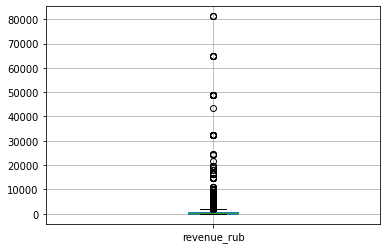

In [37]:
df[['user_id', 'revenue_rub']].boxplot()

В данных по суммарной выручке в рублях встречаются отрицательные значения, а также присутствуют выбросы

In [38]:
#Проводим фильтрацию по верхней и нижней границе
upper_limit = df['revenue_rub'].quantile(0.99)

df = df[df['revenue_rub'] <= upper_limit]

df = df[df['revenue_rub'] > 0]

In [39]:
df['revenue_rub'].describe()

count    281879.000000
mean        528.888245
std         511.717224
min           0.020000
25%         122.690002
50%         358.290009
75%         798.070007
max        2628.421631
Name: revenue_rub, dtype: float64

<AxesSubplot:>

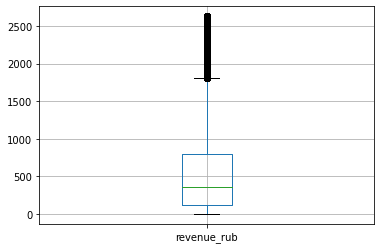

In [40]:
df[['user_id', 'revenue_rub']].boxplot()

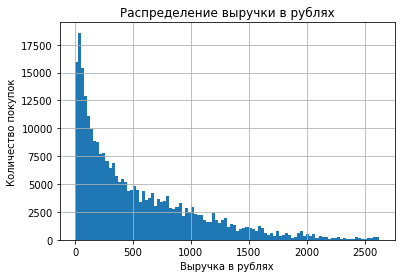

In [41]:
df['revenue_rub'].hist(bins=100)
plt.xlabel('Выручка в рублях')
plt.ylabel('Количество покупок')
plt.title('Распределение выручки в рублях')
plt.show()

In [42]:
df['tickets_count'].describe()

count    281879.000000
mean          2.744117
std           1.157190
min           1.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          47.000000
Name: tickets_count, dtype: float64

<AxesSubplot:>

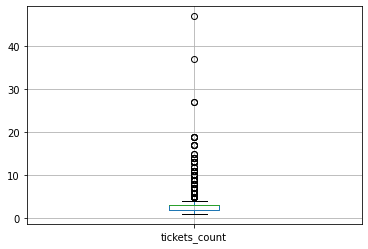

In [43]:
df[['user_id', 'tickets_count']].boxplot()

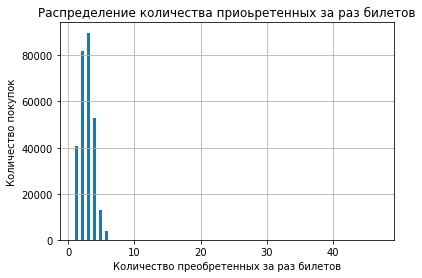

In [44]:
df['tickets_count'].hist(bins=100)
plt.xlabel('Количество преобретенных за раз билетов')
plt.ylabel('Количество покупок')
plt.title('Распределение количества приоьретенных за раз билетов')
plt.show()

Поле `tickets_count` также содержит выбросы, основная масса значений (до 75%) сосредоточена в пределах от 1 до 3 билетов. Данное поле в фильтрации не нуждается, т.к. выбросы не влияют на статистические показатели.

In [45]:
#Данные были отфильтрованы в следующем относительном значении и абсолютном:
print('Относительное количество:', (len(temp) - len(df)) / len(temp))
print('Абсолютное количество:', len(temp) - len(df))

Относительное количество: 0.03004703882509609
Абсолютное количество: 8732


**Промежуточный вывод:**
В предобработке данных было выполнено следующее: 
 - добавлен новый столбец `revenue_rub`, обозначающий суммарную выручку в рублях;
 - преобразованы типы данных int и float до минимально возможных по размеру в памяти
 - проверены значения категорий в номинальных данных, выполнена проверка на явные и неявные дубликаты
 - были проанализированы численные значения в полях `revenue_rub` и `tickets_count`.
 - датафрейм был отфильтрован по значению поля `revenue_rub` по 99% процентилю сверху и значениям выше нуля снизу.
В итоге была отфильтрована 14381 строка, что в относительном выражении - 0.05.

---

### 3. Создание профиля пользователя

В будущем отдел маркетинга планирует создать модель для прогнозирования возврата пользователей. Поэтому сейчас они просят вас построить агрегированные признаки, описывающие поведение и профиль каждого пользователя.

---

**Задача 3.1.** Постройте профиль пользователя — для каждого пользователя найдите:

- дату первого и последнего заказа;
- устройство, с которого был сделан первый заказ;
- регион, в котором был сделан первый заказ;
- билетного партнёра, к которому обращались при первом заказе;
- жанр первого посещённого мероприятия (используйте поле `event_type_main`);
- общее количество заказов;
- средняя выручка с одного заказа в рублях;
- среднее количество билетов в заказе;
- среднее время между заказами.

После этого добавьте два бинарных признака:

- `is_two` — совершил ли пользователь 2 и более заказа;
- `is_five` — совершил ли пользователь 5 и более заказов.

**Рекомендация:** перед тем как строить профиль, отсортируйте данные по времени совершения заказа.

---


In [46]:
#Проводим сортировку по дате создания заказа
df = df.sort_values(by='created_dt_msk')

In [47]:
#Проверяем результат
df.head()

,user_id,device_type_canonical,order_id,created_dt_msk,created_ts_msk,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,region_name,city_name,revenue_rub
227190,c1c7641fd348ed1,desktop,7689438,2024-06-01,2024-06-01 22:40:12,rub,779.580017,2,NaN,519414,dcf6f06f-8499-41d7-8bc2-a0e3d7afe313,концерты,Облачко,Каменевский регион,Глиногорск,779.580017
3212,02ea4583333f064,mobile,8156367,2024-06-01,2024-06-01 20:14:00,rub,480.179993,4,0.0,151378,0ebca5ab-d9ea-418c-9559-8cea0450b47f,театр,Лови билет!,Яблоневская область,Светополье,480.179993
268402,ea466fe75a365d4,mobile,499468,2024-06-01,2024-06-01 19:22:48,rub,12.290000,2,NaN,503367,784c229f-a321-4f6d-a527-c240792e03bc,другое,Билеты без проблем,Широковская область,Радужнополье,12.290000
143040,76a20aa2903dffa,mobile,1099420,2024-06-01,2024-06-01 23:42:46,rub,487.910004,2,0.0,500954,feae9484-298c-4bef-ad5f-21b4cbdb1bbf,концерты,Дом культуры,Каменевский регион,Глиногорск,487.910004
189208,9d0808e41b1be28,mobile,4798921,2024-06-01,2024-06-01 08:33:59,rub,1102.829956,3,0.0,403590,99ae2f79-da1a-41e0-8c26-7046278d188d,стендап,Облачко,Каменевский регион,Глиногорск,1102.829956


In [48]:
#Создаем профиль пользователя
user_list = df['user_id'].unique()
user_list

array(['c1c7641fd348ed1', '02ea4583333f064', 'ea466fe75a365d4', ...,
       '3203c2f16c45b2e', '20c1fd8737bb848', '21422dcff3637ee'],
      dtype=object)

In [49]:
user = pd.DataFrame()

In [50]:
user['user_id'] = user_list
user

,user_id
0,c1c7641fd348ed1
1,02ea4583333f064
2,ea466fe75a365d4
3,76a20aa2903dffa
4,9d0808e41b1be28
...,...
21695,33df8ce25b3bcc1
21696,0dfad6c3168ec70
21697,3203c2f16c45b2e
21698,20c1fd8737bb848


In [51]:
first_order = df.groupby('user_id')['created_dt_msk'].min().reset_index()
first_order.columns = ['user_id', 'first_order_date']
first_order

,user_id,first_order_date
0,0002849b70a3ce2,2024-08-20
1,0005ca5e93f2cf4,2024-07-23
2,000898990054619,2024-07-13
3,00096d1f542ab2b,2024-08-15
4,000a55a418c128c,2024-09-29
...,...,...
21695,fff13b79bd47d7c,2024-07-16
21696,fff32fc9ad0f9f6,2024-08-15
21697,fffcd3dde79eb2c,2024-06-20
21698,fffeeb3c120cf0b,2024-09-24


In [52]:
last_order = df.groupby('user_id')['created_dt_msk'].max().reset_index()
last_order.columns = ['user_id', 'last_order_date']
last_order

,user_id,last_order_date
0,0002849b70a3ce2,2024-08-20
1,0005ca5e93f2cf4,2024-10-06
2,000898990054619,2024-10-23
3,00096d1f542ab2b,2024-08-15
4,000a55a418c128c,2024-10-15
...,...,...
21695,fff13b79bd47d7c,2024-10-31
21696,fff32fc9ad0f9f6,2024-10-28
21697,fffcd3dde79eb2c,2024-10-30
21698,fffeeb3c120cf0b,2024-09-24


In [53]:
user_profile = pd.merge(user, first_order, on='user_id', how='left')
user_profile = pd.merge(user_profile, last_order, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date
0,c1c7641fd348ed1,2024-06-01,2024-10-31
1,02ea4583333f064,2024-06-01,2024-10-31
2,ea466fe75a365d4,2024-06-01,2024-10-30
3,76a20aa2903dffa,2024-06-01,2024-10-31
4,9d0808e41b1be28,2024-06-01,2024-10-31
...,...,...,...
21695,33df8ce25b3bcc1,2024-10-31,2024-10-31
21696,0dfad6c3168ec70,2024-10-31,2024-10-31
21697,3203c2f16c45b2e,2024-10-31,2024-10-31
21698,20c1fd8737bb848,2024-10-31,2024-10-31


In [54]:
first_order_region = df.groupby('user_id')[['device_type_canonical', 'region_name', 'service_name', 'event_type_main']].first().reset_index()
first_order_region.columns = ['user_id', 'first_device', 'first_order_region', 'first_order_service', 'first_order_event']
first_order_region

,user_id,first_device,first_order_region,first_order_service,first_order_event
0,0002849b70a3ce2,mobile,Каменевский регион,Край билетов,театр
1,0005ca5e93f2cf4,mobile,Каменевский регион,Мой билет,выставки
2,000898990054619,mobile,Североярская область,Лови билет!,другое
3,00096d1f542ab2b,desktop,Каменевский регион,Край билетов,театр
4,000a55a418c128c,mobile,Поленовский край,Лучшие билеты,театр
...,...,...,...,...,...
21695,fff13b79bd47d7c,mobile,Каменевский регион,Мой билет,другое
21696,fff32fc9ad0f9f6,desktop,Каменевский регион,Билеты без проблем,стендап
21697,fffcd3dde79eb2c,desktop,Каменевский регион,Билеты без проблем,концерты
21698,fffeeb3c120cf0b,desktop,Широковская область,Билеты без проблем,стендап


In [55]:
user_profile = pd.merge(user_profile, first_order_region, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event
0,c1c7641fd348ed1,2024-06-01,2024-10-31,desktop,Каменевский регион,Облачко,концерты
1,02ea4583333f064,2024-06-01,2024-10-31,mobile,Яблоневская область,Лови билет!,театр
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое
3,76a20aa2903dffa,2024-06-01,2024-10-31,mobile,Каменевский регион,Дом культуры,концерты
4,9d0808e41b1be28,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,стендап
...,...,...,...,...,...,...,...
21695,33df8ce25b3bcc1,2024-10-31,2024-10-31,mobile,Серебринская область,Билеты без проблем,другое
21696,0dfad6c3168ec70,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты
21697,3203c2f16c45b2e,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты
21698,20c1fd8737bb848,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты


In [56]:
summary_data = df.groupby('user_id').agg({'order_id':'count', 'revenue_rub':'mean', 'tickets_count':'mean'}).reset_index()
summary_data.columns = ['user_id', 'total_orders', 'mean_revenue', 'mean_order_tickets']
summary_data

,user_id,total_orders,mean_revenue,mean_order_tickets
0,0002849b70a3ce2,1,1521.939941,4.000000
1,0005ca5e93f2cf4,2,774.010010,3.000000
2,000898990054619,3,767.213318,2.666667
3,00096d1f542ab2b,1,917.830017,4.000000
4,000a55a418c128c,2,61.309998,1.500000
...,...,...,...,...
21695,fff13b79bd47d7c,9,688.043335,2.555556
21696,fff32fc9ad0f9f6,2,850.994995,2.500000
21697,fffcd3dde79eb2c,33,557.908508,2.787879
21698,fffeeb3c120cf0b,1,661.530029,2.000000


In [57]:
user_profile = pd.merge(user_profile, summary_data, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets
0,c1c7641fd348ed1,2024-06-01,2024-10-31,desktop,Каменевский регион,Облачко,концерты,349,564.200012,2.785100
1,02ea4583333f064,2024-06-01,2024-10-31,mobile,Яблоневская область,Лови билет!,театр,2913,588.198242,2.725026
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое,8,473.341248,2.125000
3,76a20aa2903dffa,2024-06-01,2024-10-31,mobile,Каменевский регион,Дом культуры,концерты,865,489.074402,2.875145
4,9d0808e41b1be28,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,стендап,624,583.604248,2.806090
...,...,...,...,...,...,...,...,...,...,...
21695,33df8ce25b3bcc1,2024-10-31,2024-10-31,mobile,Серебринская область,Билеты без проблем,другое,1,20.059999,2.000000
21696,0dfad6c3168ec70,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,125.489998,3.000000
21697,3203c2f16c45b2e,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,4,399.535004,2.250000
21698,20c1fd8737bb848,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,5,138.574005,2.200000


In [58]:
df_sorted = df.sort_values(by=['user_id', 'created_dt_msk'])

# Рассчитываем разницу во времени между последовательными заказами
df_sorted['time_diff'] = df_sorted.groupby('user_id')['created_dt_msk'].diff().dt.days

mean_order_days = df_sorted.groupby('user_id')['time_diff'].mean().reset_index()
mean_order_days.columns = ['user_id', 'mean_order_days']
mean_order_days

,user_id,mean_order_days
0,0002849b70a3ce2,NaN
1,0005ca5e93f2cf4,75.000
2,000898990054619,51.000
3,00096d1f542ab2b,NaN
4,000a55a418c128c,16.000
...,...,...
21695,fff13b79bd47d7c,13.375
21696,fff32fc9ad0f9f6,74.000
21697,fffcd3dde79eb2c,4.125
21698,fffeeb3c120cf0b,NaN


In [59]:
user_profile = pd.merge(user_profile, mean_order_days, on='user_id', how='left')
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days
0,c1c7641fd348ed1,2024-06-01,2024-10-31,desktop,Каменевский регион,Облачко,концерты,349,564.200012,2.785100,0.436782
1,02ea4583333f064,2024-06-01,2024-10-31,mobile,Яблоневская область,Лови билет!,театр,2913,588.198242,2.725026,0.052198
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое,8,473.341248,2.125000,21.571429
3,76a20aa2903dffa,2024-06-01,2024-10-31,mobile,Каменевский регион,Дом культуры,концерты,865,489.074402,2.875145,0.175926
4,9d0808e41b1be28,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,стендап,624,583.604248,2.806090,0.243981
...,...,...,...,...,...,...,...,...,...,...,...
21695,33df8ce25b3bcc1,2024-10-31,2024-10-31,mobile,Серебринская область,Билеты без проблем,другое,1,20.059999,2.000000,NaN
21696,0dfad6c3168ec70,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,125.489998,3.000000,NaN
21697,3203c2f16c45b2e,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,4,399.535004,2.250000,0.000000
21698,20c1fd8737bb848,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,5,138.574005,2.200000,0.000000


In [60]:
def is_two(row):
    if row['total_orders'] >= 2:
        row['is_two'] = 1
    else:
        row['is_two'] = 0
    return row

In [61]:
def is_five(row):
    if row['total_orders'] >= 5:
        row['is_five'] = 1
    else:
        row['is_five'] = 0
    return row

In [62]:
user_profile = user_profile.apply(is_two, axis=1)

In [63]:
user_profile = user_profile.apply(is_five, axis=1)

In [64]:
user_profile

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five
0,c1c7641fd348ed1,2024-06-01,2024-10-31,desktop,Каменевский регион,Облачко,концерты,349,564.200012,2.785100,0.436782,1,1
1,02ea4583333f064,2024-06-01,2024-10-31,mobile,Яблоневская область,Лови билет!,театр,2913,588.198242,2.725026,0.052198,1,1
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое,8,473.341248,2.125000,21.571429,1,1
3,76a20aa2903dffa,2024-06-01,2024-10-31,mobile,Каменевский регион,Дом культуры,концерты,865,489.074402,2.875145,0.175926,1,1
4,9d0808e41b1be28,2024-06-01,2024-10-31,mobile,Каменевский регион,Облачко,стендап,624,583.604248,2.806090,0.243981,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21695,33df8ce25b3bcc1,2024-10-31,2024-10-31,mobile,Серебринская область,Билеты без проблем,другое,1,20.059999,2.000000,NaN,0,0
21696,0dfad6c3168ec70,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,1,125.489998,3.000000,NaN,0,0
21697,3203c2f16c45b2e,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,4,399.535004,2.250000,0.000000,1,0
21698,20c1fd8737bb848,2024-10-31,2024-10-31,mobile,Каменевский регион,Мой билет,концерты,5,138.574005,2.200000,0.000000,1,1


In [65]:
temp2 = len(user_profile)
temp2

21700

---

**Задача 3.2.** Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

Используя данные о профилях пользователей, рассчитайте:

- общее число пользователей в выборке;
- среднюю выручку с одного заказа;
- долю пользователей, совершивших 2 и более заказа;
- долю пользователей, совершивших 5 и более заказов.

Также изучите статистические показатели:

- по общему числу заказов;
- по среднему числу билетов в заказе;
- по среднему количеству дней между покупками.

По результатам оцените данные: достаточно ли их по объёму, есть ли аномальные значения в данных о количестве заказов и среднем количестве билетов?

Если вы найдёте аномальные значения, опишите их и примите обоснованное решение о том, как с ними поступить:

- Оставить и учитывать их при анализе?
- Отфильтровать данные по какому-то значению, например, по 95-му или 99-му перцентилю?

Если вы проведёте фильтрацию, то вычислите объём отфильтрованных данных и выведите статистические показатели по обновлённому датасету.

In [66]:
#Общее число пользователей в выборке
user_profile['user_id'].count()

21700

In [67]:
user_profile.shape[0]

21700

In [68]:
#Средняя выручка с одного заказа
user_profile['mean_revenue'].mean()

551.8789863489338

In [69]:
#Доля пользователей 2 и более заказа
user_profile['is_two'].sum() / user_profile.shape[0]

0.6166820276497695

In [70]:
#Доля пользователей 5 и более заказов
user_profile['is_five'].sum() / user_profile.shape[0]

0.2886635944700461

In [71]:
#Статистические данные по общему количеству заказов
user_profile['total_orders'].describe()

count    21700.000000
mean        12.989816
std        119.766778
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max       9987.000000
Name: total_orders, dtype: float64

В данных общего количества заказов явно присутствуют выбросы. Их необходимо отфильтровать, т.к. целевой аудиторией являются люди с небольшим количеством заказов. Попробуем отфильтровать сначала по 99 процентилю

In [72]:
#Фильтруем по 99 процентилю
max_value = user_profile['total_orders'].quantile(0.99)
user_profile = user_profile[user_profile['total_orders'] <= max_value]

In [73]:
#Снова смотрим статистику
user_profile['total_orders'].describe()

count    21483.000000
mean         6.404506
std         13.982574
min          1.000000
25%          1.000000
50%          2.000000
75%          5.000000
max        150.000000
Name: total_orders, dtype: float64

Максимальное значение стало меньше, однако всё равно ещё во много раз больше всех остальных и сильно влияет на статистические показатели. Отфильтруем по 95 процентилю

In [74]:
#Фильтруем по 95 процентилю
max_value = user_profile['total_orders'].quantile(0.95)
user_profile = user_profile[user_profile['total_orders'] <= max_value]

In [75]:
#Снова смотрим статистику
user_profile['total_orders'].describe()

count    20447.000000
mean         3.814496
std          4.541511
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         26.000000
Name: total_orders, dtype: float64

Теперь максимальное значение не так сильно удалено от всех остальных и не сильно влияет на статистику.

In [76]:
#Статистические данные по среднему числу билетов в заказе
user_profile['mean_order_tickets'].describe()

count    20447.000000
mean         2.746556
std          0.939049
min          1.000000
25%          2.000000
50%          2.750000
75%          3.166667
max         11.000000
Name: mean_order_tickets, dtype: float64

Данные без выбросов

In [77]:
#Статистические данные по среднему количеству дней между покупками
user_profile['mean_order_days'].describe()

count    12129.000000
mean        17.286567
std         23.000180
min          0.000000
25%          1.000000
50%          9.777778
75%         22.500000
max        148.000000
Name: mean_order_days, dtype: float64

В этих данных есть выросы, однако их необходимо оставить, поскольку нам важен каждый пользователь - вне зависимости от того, когда он вернулся за новым заказом.

In [78]:
#Итоги фильтрации
print('Отфильтровано строк:', temp2 - user_profile.shape[0])
print('Относительная величина фильтрации:', (temp2 - user_profile.shape[0]) / temp2)

Отфильтровано строк: 1253
Относительная величина фильтрации: 0.057741935483870965


**Общий промежуточный вывод**

Данных достаточно по объему, они репрезентативны. Аномалии были выявлены в общем количестве заказов и среднем количестве дней между заказами. В первом случае данные были отфильтрованы по 95 процентилю, так как искажали статистику и не отражали целевую аудиторию, во втором - принято решение оставить их, т.к. важен каждый пользователь, независимо от того, через сколько дней он вернулся за заказом.

---

### 4. Исследовательский анализ данных

Следующий этап — исследование признаков, влияющих на возврат пользователей, то есть на совершение повторного заказа. Для этого используйте профили пользователей.



#### 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу

Исследуйте признаки, описывающие первый заказ пользователя, и выясните, влияют ли они на вероятность возвращения пользователя.

---

**Задача 4.1.1.** Изучите распределение пользователей по признакам.

- Сгруппируйте пользователей:
    - по типу их первого мероприятия;
    - по типу устройства, с которого совершена первая покупка;
    - по региону проведения мероприятия из первого заказа;
    - по билетному оператору, продавшему билеты на первый заказ.
- Подсчитайте общее количество пользователей в каждом сегменте и их долю в разрезе каждого признака. Сегмент — это группа пользователей, объединённых определённым признаком, то есть объединённые принадлежностью к категории. Например, все клиенты, сделавшие первый заказ с мобильного телефона, — это сегмент.
- Ответьте на вопрос: равномерно ли распределены пользователи по сегментам или есть выраженные «точки входа» — сегменты с наибольшим числом пользователей?

---


In [79]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_event')['user_id'].count()

first_order_event
выставки     393
другое      4953
концерты    9153
спорт        738
стендап     1078
театр       4036
ёлки          96
Name: user_id, dtype: int64

In [80]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_event')['user_id'].count() / user_profile.shape[0]

first_order_event
выставки    0.019220
другое      0.242236
концерты    0.447645
спорт       0.036093
стендап     0.052722
театр       0.197388
ёлки        0.004695
Name: user_id, dtype: float64

In [81]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_device')['user_id'].count()

first_device
desktop     3489
mobile     16958
Name: user_id, dtype: int64

In [82]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_device')['user_id'].count() / user_profile.shape[0]

first_device
desktop    0.170636
mobile     0.829364
Name: user_id, dtype: float64

In [83]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_region')['user_id'].count().sort_values()

first_order_region
Яснопольский округ             1
Сосноводолинская область       1
Верхозёрский край              1
Светолесский край              1
Верховинская область           2
                            ... 
Малиновоярский округ         511
Озернинский край             662
Широковская область         1187
Североярская область        3589
Каменевский регион          6623
Name: user_id, Length: 81, dtype: int64

In [84]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_region')['user_id'].count().sort_values() / user_profile.shape[0]

first_order_region
Яснопольский округ          0.000049
Сосноводолинская область    0.000049
Верхозёрский край           0.000049
Светолесский край           0.000049
Верховинская область        0.000098
                              ...   
Малиновоярский округ        0.024991
Озернинский край            0.032376
Широковская область         0.058053
Североярская область        0.175527
Каменевский регион          0.323911
Name: user_id, Length: 81, dtype: float64

In [85]:
#Выводим абсолютное количество пользователей в категориях
user_profile.groupby('first_order_service')['user_id'].count().sort_values()

first_order_service
Зе Бест!                     1
Лимоны                       2
Тех билет                    3
Билет по телефону            6
Вперёд!                      7
Кино билет                   9
КарандашРУ                  14
Шоу начинается!             18
Цвет и билет                21
Реестр                      27
Телебилет                   28
Радио ticket                35
Росбилет                    38
Crazy ticket!               44
Быстрый кассир              54
Восьмёрка                   83
Выступления.ру              96
Show_ticket                153
Быстробилет                159
Мир касс                   198
За билетом!                199
Городской дом культуры     213
Тебе билет!                297
Яблоко                     307
Дом культуры               337
Край билетов               437
Прачечная                  544
Лучшие билеты             1124
Весь в билетах            1228
Облачко                   2119
Билеты в руки             2399
Лови билет!        

In [86]:
#Выводим долю пользователей по категориям
user_profile.groupby('first_order_service')['user_id'].count().sort_values() / user_profile.shape[0]

first_order_service
Зе Бест!                  0.000049
Лимоны                    0.000098
Тех билет                 0.000147
Билет по телефону         0.000293
Вперёд!                   0.000342
Кино билет                0.000440
КарандашРУ                0.000685
Шоу начинается!           0.000880
Цвет и билет              0.001027
Реестр                    0.001320
Телебилет                 0.001369
Радио ticket              0.001712
Росбилет                  0.001858
Crazy ticket!             0.002152
Быстрый кассир            0.002641
Восьмёрка                 0.004059
Выступления.ру            0.004695
Show_ticket               0.007483
Быстробилет               0.007776
Мир касс                  0.009684
За билетом!               0.009732
Городской дом культуры    0.010417
Тебе билет!               0.014525
Яблоко                    0.015014
Дом культуры              0.016482
Край билетов              0.021372
Прачечная                 0.026605
Лучшие билеты             0.054971


**Промежуточный вывод**

Пользователи распределены по серментам неравномерно, присутствуют, так называемые, "точки входа". Например: по типу мероприятия больше всего пользователей купили билеты на `концентры`, `другое` и `театр`; по устройству - абсолютный лидер `mobile`; по региону первого заказа больше всего выделяются `Широковская область`,`Североярская область` и `Каменевский регион`; по оператору первого заказа можно выделить топ-5 операторов: `Облачко`, `Билеты в руки`, `Лови билет!`, `Мой билет` и `Билеты без проблем`.

---

**Задача 4.1.2.** Проанализируйте возвраты пользователей:

- Для каждого сегмента вычислите долю пользователей, совершивших два и более заказа.
- Визуализируйте результат подходящим графиком. Если сегментов слишком много, то поместите на график только 10 сегментов с наибольшим количеством пользователей. Такое возможно с сегментами по региону и по билетному оператору.
- Ответьте на вопросы:
    - Какие сегменты пользователей чаще возвращаются на Яндекс Афишу?
    - Наблюдаются ли успешные «точки входа» — такие сегменты, в которых пользователи чаще совершают повторный заказ, чем в среднем по выборке?

При интерпретации результатов учитывайте размер сегментов: если в сегменте мало пользователей (например, десятки), то доли могут быть нестабильными и недостоверными, то есть показывать широкую вариацию значений.

---


In [87]:
#Доля 2 и более заказов для мероприятия
is_two_event = user_profile.groupby('first_order_event')['is_two'].sum() / user_profile.groupby('first_order_event')['user_id'].count()
is_two_event = is_two_event.sort_values()
is_two_event

first_order_event
спорт       0.532520
ёлки        0.562500
другое      0.572178
стендап     0.594620
концерты    0.598820
театр       0.614718
выставки    0.623410
dtype: float64

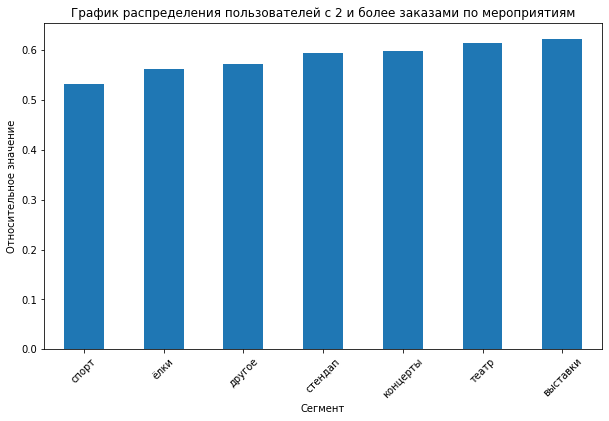

In [88]:
#Визуализируем
is_two_event.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по мероприятиям')
plt.show()

In [89]:
#Доля 2 и более заказов для устройства
is_two_device = user_profile.groupby('first_device')['is_two'].sum() / user_profile.groupby('first_device')['user_id'].count()
is_two_device = is_two_device.sort_values()
is_two_device

first_device
mobile     0.588572
desktop    0.615649
dtype: float64

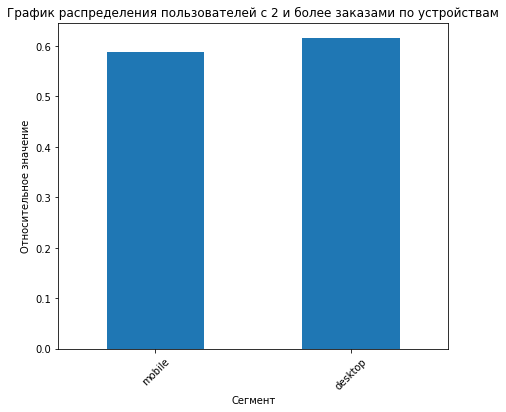

In [90]:
#Визуализируем
is_two_device.plot(kind='bar', rot=45, figsize=(7, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по устройствам')
plt.show()

In [91]:
#Доля 2 и более заказов для региона
is_two_region = user_profile.groupby('first_order_region')['is_two'].sum() / user_profile.groupby('first_order_region')['user_id'].count()
is_two_region = is_two_region.sort_values()
is_two_region

first_order_region
Яснопольский округ          0.000000
Островогорский округ        0.000000
Светолесский край           0.000000
Сосноводолинская область    0.000000
Крутоводский регион         0.333333
                              ...   
Лесостепной край            0.672727
Тихолесский край            0.727273
Радужнопольский край        0.761905
Озернопольская область      0.884615
Верхозёрский край           1.000000
Length: 81, dtype: float64

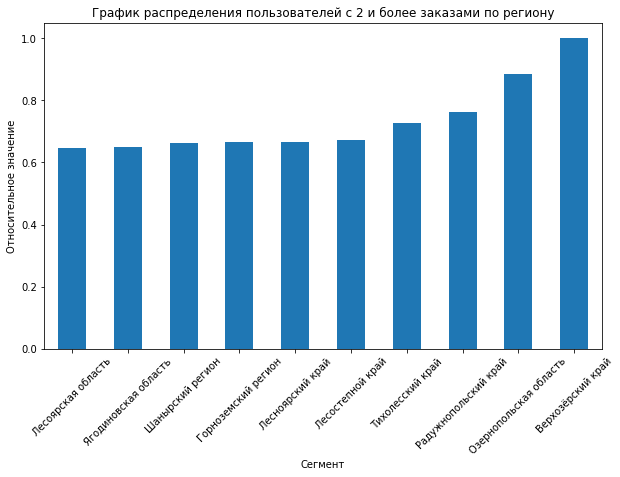

In [92]:
#Визуализируем
is_two_region_10 = is_two_region.tail(10)
is_two_region_10.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по региону')
plt.show()

In [93]:
#Доля 2 и более заказов для билетного оператора
is_two_service = user_profile.groupby('first_order_service')['is_two'].sum() / user_profile.groupby('first_order_service')['user_id'].count()
is_two_service = is_two_service.sort_values()
is_two_service

first_order_service
Шоу начинается!           0.277778
Тех билет                 0.333333
КарандашРУ                0.357143
Радио ticket              0.400000
Телебилет                 0.464286
Лимоны                    0.500000
Яблоко                    0.514658
Кино билет                0.555556
Вперёд!                   0.571429
Билеты без проблем        0.576842
Городской дом культуры    0.582160
За билетом!               0.582915
Быстробилет               0.584906
Мой билет                 0.587430
Тебе билет!               0.589226
Лови билет!               0.592897
Лучшие билеты             0.594306
Прачечная                 0.597426
Облачко                   0.599339
Билеты в руки             0.606503
Весь в билетах            0.609935
Мир касс                  0.616162
Цвет и билет              0.619048
Выступления.ру            0.625000
Дом культуры              0.626113
Росбилет                  0.631579
Край билетов              0.636156
Show_ticket               0.640523


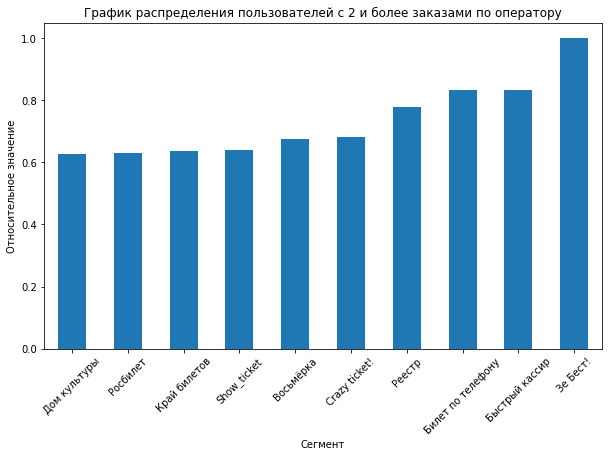

In [94]:
#Визуализируем
is_two_service_10 = is_two_service.tail(10)
is_two_service_10.plot(kind='bar', rot=45, figsize=(10, 6))
plt.xlabel('Сегмент')
plt.ylabel('Относительное значение')
plt.title('График распределения пользователей с 2 и более заказами по оператору')
plt.show()

**Вывод**

Чаще возвращаются пользователи, купившие в первый раз билет на выставки, совершившие первый заказ с мобильного телефона, из Верхнеозерского края и пользующиеся оператором "Зе Бест!".

---

**Задача 4.1.3.** Опираясь на выводы из задач выше, проверьте продуктовые гипотезы:

- **Гипотеза 1.** Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.
- **Гипотеза 2.** В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

---

**Выводы по гипотезе 1**

Распределение по мероприятию первого заказа при повторных заказах действительно есть, однако градация в относительной величине не так велика, относительные значения достаточно близко друг другу. Тем не менее выделить можно лидера - `выставки`. 

В случае же со спортивными мероприятиями и концертами гипотеза не подтверждается, пользователи, которые совершили первый заказ на спортивные мероприятия находятся в самом низу топа по возвращениям.

**Выводы по гипотезе 2**

Гипотеза не подтверждается. К примеру, регион-лидер по возвращениям находится в самом низу топа по общему количеству пользователей. Регионов-лидеров по количеству пользователей не наблюдается в топе регионов по возвращениям.

**Дополнение**

Также стоит отметить, что похожая ситуация (как с регионами) наблюдается и с операторами: оператор-лидер по числу вернувшихся клиентов находится в самом низу топа по общему количеству пользователей.

---

#### 4.2. Исследование поведения пользователей через показатели выручки и состава заказа

Изучите количественные характеристики заказов пользователей, чтобы узнать среднюю выручку сервиса с заказа и количество билетов, которое пользователи обычно покупают.

Эти метрики важны не только для оценки выручки, но и для оценки вовлечённости пользователей. Возможно, пользователи с более крупными и дорогими заказами более заинтересованы в сервисе и поэтому чаще возвращаются.

---

**Задача 4.2.1.** Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

- Постройте сравнительные гистограммы распределения средней выручки с билета (`avg_revenue_rub`):
    - для пользователей, совершивших один заказ;
    - для вернувшихся пользователей, совершивших 2 и более заказа.
- Ответьте на вопросы:
    - В каких диапазонах средней выручки концентрируются пользователи из каждой группы?
    - Есть ли различия между группами?

Текст на сером фоне:
    
**Рекомендация:**

1. Используйте одинаковые интервалы (`bins`) и прозрачность (`alpha`), чтобы визуально сопоставить распределения.
2. Задайте параметру `density` значение `True`, чтобы сравнивать форму распределений, даже если число пользователей в группах отличается.

---


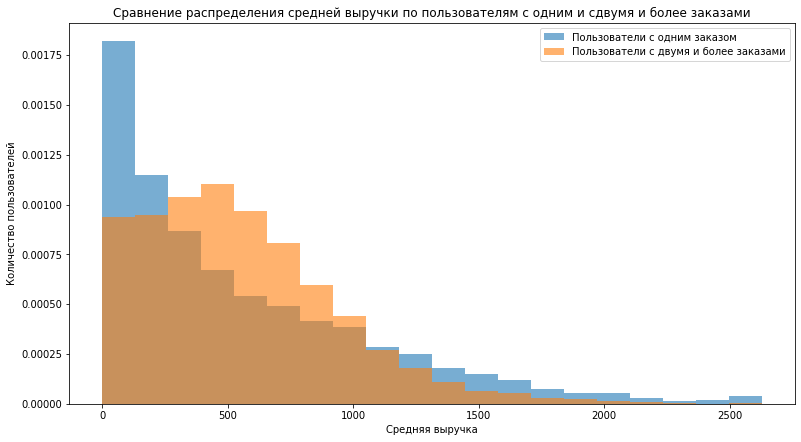

In [95]:
plt.figure(figsize=(13, 7))
one_order_users = user_profile[user_profile['is_two'] == 0]['mean_revenue']
two_order_users = user_profile[user_profile['is_two'] == 1]['mean_revenue']
plt.hist(one_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с одним заказом')
plt.hist(two_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с двумя и более заказами')
plt.xlabel('Средняя выручка')
plt.ylabel('Количество пользователей')
plt.title('Сравнение распределения средней выручки по пользователям с одним и сдвумя и более заказами')
plt.legend()
plt.show()

**Вывод**

Пользователи с одним заказом сконцентрированы в левой части графика около значений, близких к нулю.

Пользователи с двумя и более заказами сконцентрированы в области от 0 до примерно 750 рублей по средней выручке.

Из всего этого можно сделать вывод, что пользователи с более дорогими заказами более заинтересованы в сервисе.

---

**Задача 4.2.2.** Сравните распределение по средней выручке с заказа в двух группах пользователей:

- совершившие 2–4 заказа;
- совершившие 5 и более заказов.

Ответьте на вопрос: есть ли различия по значению средней выручки с заказа между пользователями этих двух групп?

---


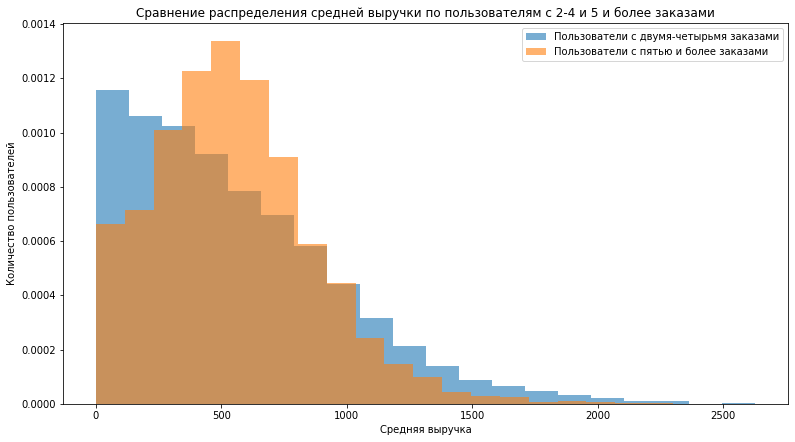

In [96]:
plt.figure(figsize=(13, 7))
two_order_users = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['mean_revenue']
five_order_users = user_profile[user_profile['is_five'] == 1]['mean_revenue']
plt.hist(two_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с двумя-четырьмя заказами')
plt.hist(five_order_users, bins=20, alpha=0.6, density=True, label='Пользователи с пятью и более заказами')
plt.xlabel('Средняя выручка')
plt.ylabel('Количество пользователей')
plt.title('Сравнение распределения средней выручки по пользователям с 2-4 и 5 и более заказами')
plt.legend()
plt.show()

**Вывод**

Пользователи с 5 и более заказами имеют ярко выраженный пик около значения в 500 рублей средней выручки, в то же время пользователи с 2-4 заказами имеют максимум, близкий к нулю, а остальные значения по выручке далее представлены по нисходящей тенденции. Это снова подтверждает, что пользователи с более дорогими заказами более заинтересованы в возвращении на сервис.

---

**Задача 4.2.3.** Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.

- Изучите распределение пользователей по среднему количеству билетов в заказе (`avg_tickets_count`) и опишите основные наблюдения.
- Разделите пользователей на несколько сегментов по среднему количеству билетов в заказе:
    - от 1 до 2 билетов;
    - от 2 до 3 билетов;
    - от 3 до 5 билетов;
    - от 5 и более билетов.
- Для каждого сегмента подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы.
- Ответьте на вопросы:
    - Как распределены пользователи по сегментам — равномерно или сконцентрировано?
    - Есть ли сегменты с аномально высокой или низкой долей повторных покупок?

---

In [97]:
#1-2 билета
one_two_tickets = user_profile[user_profile['mean_order_tickets'] < 2]['user_id'].count()
one_two_tickets_back = user_profile[user_profile['mean_order_tickets'] < 2]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 1 до 2:', one_two_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 1 до 2:', one_two_tickets_back / one_two_tickets)

Общее число пользователей со средним количеством билетов в заказе от 1 до 2: 2387
Доля вернувшихся пользователей со средним количеством билетов в заказе от 1 до 2: 0.5111018014243821


In [98]:
#2-3 билета
two_three_tickets = user_profile[(user_profile['mean_order_tickets'] >= 2) & (user_profile['mean_order_tickets'] < 3)]['user_id'].count()
two_three_tickets_back = user_profile[(user_profile['mean_order_tickets'] >= 2) & (user_profile['mean_order_tickets'] < 3)]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 2 до 3:', two_three_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 2 до 3:', two_three_tickets_back / two_three_tickets)

Общее число пользователей со средним количеством билетов в заказе от 2 до 3: 8552
Доля вернувшихся пользователей со средним количеством билетов в заказе от 2 до 3: 0.7080215154349859


In [99]:
#3-5 билетов
three_five_tickets = user_profile[(user_profile['mean_order_tickets'] >= 3) & (user_profile['mean_order_tickets'] < 5)]['user_id'].count()
three_five_tickets_back = user_profile[(user_profile['mean_order_tickets'] >= 3) & (user_profile['mean_order_tickets'] < 5)]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 3 до 5:', three_five_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 3 до 5:', three_five_tickets_back / three_five_tickets)

Общее число пользователей со средним количеством билетов в заказе от 3 до 5: 8851
Доля вернувшихся пользователей со средним количеством билетов в заказе от 3 до 5: 0.5344028923285504


In [100]:
#5 и более билетов
five_and_more_tickets = user_profile[user_profile['mean_order_tickets'] >= 5]['user_id'].count()
five_and_more_tickets_back = user_profile[user_profile['mean_order_tickets'] >= 5]['is_two'].sum()
print('Общее число пользователей со средним количеством билетов в заказе от 5 и выше:', five_and_more_tickets)
print('Доля вернувшихся пользователей со средним количеством билетов в заказе от 5 и выше:', five_and_more_tickets_back / five_and_more_tickets)

Общее число пользователей со средним количеством билетов в заказе от 5 и выше: 657
Доля вернувшихся пользователей со средним количеством билетов в заказе от 5 и выше: 0.1887366818873668


**Вывод**

Основная масса пользователей сосредоточена в сегментах `2-3 билета` и `3-5 билетов`, затем идет сегмент `1-2 билета` и меньше всего пользователей в сегменте `5 и более билетов`. 

При этом примерно одинаковые доли вернувшихся пользователей в сегментах `1-2 билета` и `3-5 билетов` (примерно 50%), аутсайдер - `5 и более билетов` (19%), самая высокая доля вернувшихся в сегменте `2-3 билета` (71%).

На основе этого можно сделать следующий вывод: объем заказа действительно влияет на возврат пользователя, но до определенной границы - в данном случае `2-3 билета`, большие объемы заказов меньше приводят к возврату пользователей.

---

#### 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучите временные параметры, связанные с первым заказом пользователей:

- день недели первой покупки;
- время с момента первой покупки — лайфтайм;
- средний интервал между покупками пользователей с повторными заказами.

---

**Задача 4.3.1.** Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

- По данным даты первого заказа выделите день недели.
- Для каждого дня недели подсчитайте общее число пользователей и долю пользователей, совершивших повторные заказы. Результаты визуализируйте.
- Ответьте на вопрос: влияет ли день недели, в которую совершена первая покупка, на вероятность возврата клиента?

---


In [101]:
day_of_week_df = user_profile.copy()
day_of_week_df.head()

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое,8,473.341248,2.125000,21.571429,1,1
5,09de49a2021a568,2024-06-01,2024-06-01,mobile,Островная область,Билеты без проблем,театр,1,339.420013,2.000000,NaN,0,0
6,8d04c9f8df7be5d,2024-06-01,2024-10-16,mobile,Каменевский регион,Билеты без проблем,другое,7,882.854309,2.857143,22.833333,1,1
8,fbc938ceaef1c45,2024-06-01,2024-10-17,mobile,Североярская область,Билеты в руки,концерты,13,519.166138,3.076923,11.500000,1,1
16,8e426e220be8096,2024-06-01,2024-10-16,mobile,Североярская область,Реестр,концерты,9,806.597961,2.555556,17.125000,1,1


In [102]:
day_of_week_df['day_of_week'] = day_of_week_df['first_order_date'].dt.day_name()

In [103]:
day_of_week_df.head()

,user_id,first_order_date,last_order_date,first_device,first_order_region,first_order_service,first_order_event,total_orders,mean_revenue,mean_order_tickets,mean_order_days,is_two,is_five,day_of_week
2,ea466fe75a365d4,2024-06-01,2024-10-30,mobile,Широковская область,Билеты без проблем,другое,8,473.341248,2.125000,21.571429,1,1,Saturday
5,09de49a2021a568,2024-06-01,2024-06-01,mobile,Островная область,Билеты без проблем,театр,1,339.420013,2.000000,NaN,0,0,Saturday
6,8d04c9f8df7be5d,2024-06-01,2024-10-16,mobile,Каменевский регион,Билеты без проблем,другое,7,882.854309,2.857143,22.833333,1,1,Saturday
8,fbc938ceaef1c45,2024-06-01,2024-10-17,mobile,Североярская область,Билеты в руки,концерты,13,519.166138,3.076923,11.500000,1,1,Saturday
16,8e426e220be8096,2024-06-01,2024-10-16,mobile,Североярская область,Реестр,концерты,9,806.597961,2.555556,17.125000,1,1,Saturday


In [104]:
days_amount = day_of_week_df.groupby('day_of_week')['user_id'].count()
days_amount

day_of_week
Friday       3112
Monday       2765
Saturday     3069
Sunday       2599
Thursday     2987
Tuesday      2981
Wednesday    2934
Name: user_id, dtype: int64

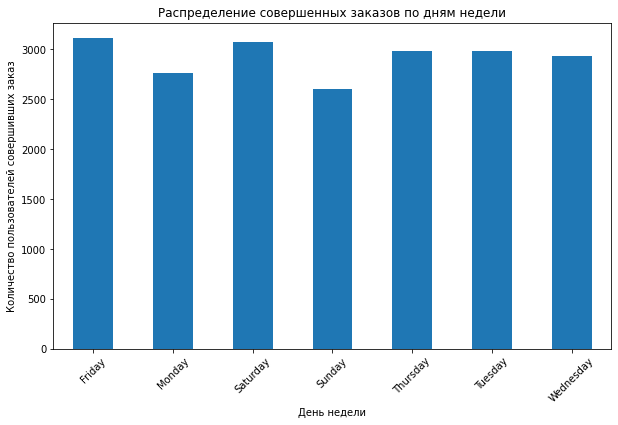

In [105]:
plt.figure(figsize=(10, 6))
days_amount.plot(kind='bar', rot=45)
plt.xlabel('День недели')
plt.ylabel('Количество пользователей совершивших заказ')
plt.title('Распределение совершенных заказов по дням недели')
plt.show()

In [106]:
days_amount_back = day_of_week_df.groupby('day_of_week')['is_two'].sum() / days_amount
days_amount_back

day_of_week
Friday       0.583869
Monday       0.607957
Saturday     0.600847
Sunday       0.577530
Thursday     0.579846
Tuesday      0.594767
Wednesday    0.607021
dtype: float64

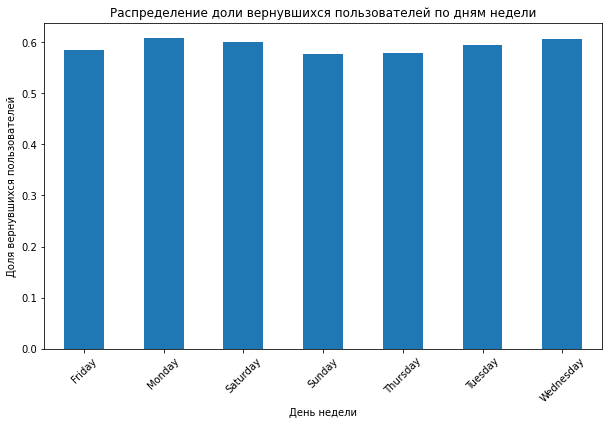

In [107]:
plt.figure(figsize=(10, 6))
days_amount_back.plot(kind='bar', rot=45)
plt.xlabel('День недели')
plt.ylabel('Доля вернувшихся пользователей')
plt.title('Распределение доли вернувшихся пользователей по дням недели')
plt.show()

**Вывод**

Значения в обоих признаках расположены довольно близко. Больше всего заказов происходит в пятницу и субботу, а больше всего вернувшихся пользователей из числа тех, кто совершил первый заказ в понедельник и среду.

Из этого можно сделать вывод о том, что день недели, в который был совершен первый заказ, не влияет на возвращение клиента.

---

**Задача 4.3.2.** Изучите, как средний интервал между заказами влияет на удержание клиентов.

- Рассчитайте среднее время между заказами для двух групп пользователей:
    - совершившие 2–4 заказа;
    - совершившие 5 и более заказов.
- Исследуйте, как средний интервал между заказами влияет на вероятность повторного заказа, и сделайте выводы.

---


In [108]:
avg_order_time_two_four = user_profile[(user_profile['is_two'] == 1) & (user_profile['is_five'] == 0)]['mean_order_days'].mean()
print('Среднее количество дней между заказами в категории 2-4 заказа:', avg_order_time_two_four)

Среднее количество дней между заказами в категории 2-4 заказа: 21.388404982673034


In [109]:
avg_order_time_five = user_profile[user_profile['is_five'] == 1]['mean_order_days'].mean()
print('Среднее количество дней между заказами в категории 5 и более заказов:', avg_order_time_five)

Среднее количество дней между заказами в категории 5 и более заказов: 11.460009697244615


**Вывод**

Среднее количество дней между заказами в категии `5 и более заказов` меньше в два раза, чем в категории `2-4 заказа`. Из чего можно сделать вывод, что чем меньше средний интервал заказов, тем больше вероятность возвращения пользователя.

---

#### 4.4. Корреляционный анализ количества покупок и признаков пользователя

Изучите, какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок. Для этого используйте универсальный коэффициент корреляции `phi_k`, который позволяет анализировать как числовые, так и категориальные признаки.

---

**Задача 4.4.1:** Проведите корреляционный анализ:
- Рассчитайте коэффициент корреляции `phi_k` между признаками профиля пользователя и числом заказов (`total_orders`). При необходимости используйте параметр `interval_cols` для определения интервальных данных.
- Проанализируйте полученные результаты. Если полученные значения будут близки к нулю, проверьте разброс данных в `total_orders`. Такое возможно, когда в данных преобладает одно значение: в таком случае корреляционный анализ может показать отсутствие связей. Чтобы этого избежать, выделите сегменты пользователей по полю `total_orders`, а затем повторите корреляционный анализ. Выделите такие сегменты:
    - 1 заказ;
    - от 2 до 4 заказов;
    - от 5 и выше.
- Визуализируйте результат корреляции с помощью тепловой карты.
- Ответьте на вопрос: какие признаки наиболее связаны с количеством заказов?

---

In [110]:
correlation_matrix = user_profile.phik_matrix(interval_cols=['total_orders', 'mean_revenue', 'mean_order_tickets', 'mean_order_days'])

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable user_id is large: 20447. Are you sure this is not an interval variable? Analysis for pairs of variables including user_id can be slow.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:255: UserWarning: Many cells: 3128391. Are interval variables set correctly?
  warnings.warn(


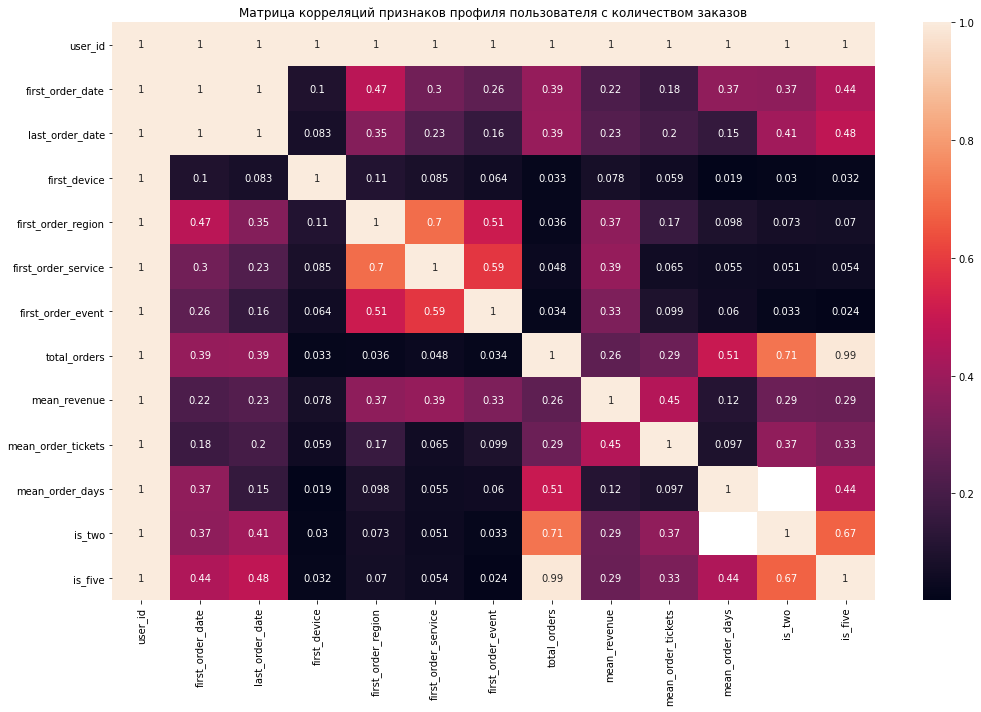

In [112]:
#Выводим матрицу корреляций
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Матрица корреляций признаков профиля пользователя с количеством заказов')
plt.tight_layout()
plt.show()

**Вывод**

В матрице корреляций полученные значения не все близки к нулю, поэтому дополнительно выделять сегменты не требуется. 

По полученным значениям можно сделать следующий вывод: поле `total_orders` имеет сильную связь с полем `mean_order_days`, умеренную связь с полями `first_order_date`, `last_order_date` и слабую связь с полями `mean_revenue` и `mean_order_tickets`.

### 5. Общий вывод и рекомендации

В конце проекта напишите общий вывод и рекомендации: расскажите заказчику, на что нужно обратить внимание. В выводах кратко укажите:

- **Информацию о данных**, с которыми вы работали, и то, как они были подготовлены: например, расскажите о фильтрации данных, переводе тенге в рубли, фильтрации выбросов.
- **Основные результаты анализа.** Например, укажите:
    - Сколько пользователей в выборке? Как распределены пользователи по числу заказов? Какие ещё статистические показатели вы подсчитали важным во время изучения данных?
    - Какие признаки первого заказа связаны с возвратом пользователей?
    - Как связаны средняя выручка и количество билетов в заказе с вероятностью повторных покупок?
    - Какие временные характеристики влияют на удержание (день недели, интервалы между покупками)?
    - Какие характеристики первого заказа и профиля пользователя могут быть связаны с числом покупок согласно результатам корреляционного анализа?
- Дополните выводы информацией, которая покажется вам важной и интересной. Следите за общим объёмом выводов — они должны быть компактными и ёмкими.

В конце предложите заказчику рекомендации о том, как именно действовать в его ситуации. Например, укажите, на какие сегменты пользователей стоит обратить внимание в первую очередь, а какие нуждаются в дополнительных маркетинговых усилиях.

**Финальный вывод**

В данном проекте была проведена работа с данными пользователей Яндекс.Афиши, которые содержали 290611 строк. 

На этапе преобработки данных было выполнено следующее:
 - добавлен новый столбец revenue_rub, обозначающий суммарную выручку в рублях, т.к. часть данных о выручке представлена в тенге;
 - преобразованы типы данных int и float до минимально возможных по размеру в памяти
 - проверены значения категорий в номинальных данных, выполнена проверка на явные и неявные дубликаты
 - были проанализированы численные значения в полях revenue_rub и tickets_count.
 - датафрейм был отфильтрован по значению поля revenue_rub по 99% процентилю сверху и значениям выше нуля снизу. В итоге была отфильтрована 14381 строка, что в относительном выражении - 0.05.

*Основные результаты анализа*

На основе выгруженных данных был создан датафрейм профиля пользователя, содержащий 21700 строк и 10 столбцов. Полученный датафрейм также был проанализирован на выбросы и аномалии, в результате чего было отфильтровано 1253 строк.

Пользователи распределены по сегментам неравномерно, присутствуют, так называемые, "точки входа". Например: по типу мероприятия больше всего пользователей купили билеты на концентры, другое и театр; по устройству - абсолютный лидер mobile; по региону первого заказа больше всего выделяются Широковская область, Североярская область и Каменевский регион; по оператору первого заказа можно выделить топ-5 операторов: Облачко, Билеты в руки, Лови билет!, Мой билет и Билеты без проблем.

Чаще возвращаются пользователи, купившие в первый раз билет на выставки, совершившие первый заказ с мобильного телефона, из Верхнеозерского края и пользующиеся оператором "Зе Бест!".

Был проведен анализ влияния стоимости заказа на возвращение пользователя на платформу.

Пользователи с одним заказом сконцентрированы в левой части графика совместного распределения средней стоимости заказа около значений, близких к нулю.
Пользователи с двумя и более заказами сконцентрированы в области от 0 до примерно 750 рублей по средней выручке.
Из всего этого можно сделать вывод, что пользователи с более дорогими заказами более заинтересованы в сервисе.

Пользователи с 5 и более заказами имеют ярко выраженный пик около значения в 500 рублей средней выручки, в то же время пользователи с 2-4 заказами имеют максимум, близкий к нулю, а остальные значения по выручке далее представлены по нисходящей тенденции. Это снова подтверждает, что пользователи с более дорогими заказами более заинтересованы в возвращении на сервис.

Основная масса пользователей сосредоточена в сегментах 2-3 билета и 3-5 билетов, затем идет сегмент 1-2 билета и меньше всего пользователей в сегменте 5 и более билетов.
При этом примерно одинаковые доли вернувшихся пользователей в сегментах 1-2 билета и 3-5 билетов (примерно 50%), аутсайдер - 5 и более билетов (19%), самая высокая доля вернувшихся в сегменте 2-3 билета (71%).

На основе этого можно сделать следующий вывод: объем заказа действительно влияет на возврат пользователя, но до определенной границы - в данном случае 2-3 билета, большие объемы заказов меньше приводят к возврату пользователей.

Также был проведен анализ зависимости дня недели первого заказа на возвращение пользователя.
Больше всего заказов происходит в пятницу и субботу, а больше всего вернувшихся пользователей из числа тех, кто совершил первый заказ в понедельник и среду.

Из этого можно сделать вывод о том, что день недели, в который был совершен первый заказ, не влияет на возвращение клиента.

Среднее количество дней между заказами в категии 5 и более заказов меньше в два раза, чем в категории 2-4 заказа. Из чего можно сделать вывод, что чем меньше средний интервал заказов, тем больше вероятность возвращения пользователя.

В завершение была построена матрица корреляций количества заказов с остальными признаками профиля пользователя. Был получен следующий результат:

Поле total_orders имеет сильную связь с полем mean_order_days, умеренную связь с полями first_order_date, last_order_date и слабую связь с полями mean_revenue и mean_order_tickets.

**Рекомендации**

По результатам анализа будет релевантна следующая рекомндация: необходимо в первую очередь обратить внимание на пользователей по следующим параметрам: 
 - средний интервал заказов: чем меньше интервал заказов у пользователя, тем он более склонен вернуться на платформу
 - средняя цена заказа: чем выше средняя цена заказа, тем более склонен пользователь вернуться
 - количество билетов в заказе: анализ выявил целевую аудиторию с 2-3 билетами в заказе
 
Также необходимо обратить внимание на регионы и операторов, у которых процент вернувшихся пользователей очень высок, в данном случае это оператор "Зе Бест!" и регион "Верхнеозерский край". Помимо этого, стоит обратить внимание на категорию "выставки" и пользователей мобильных приложений. Также необходимо учитывать время, когда покупают билеты больше всего - пятница и суббота.

### 6. Финализация проекта и публикация в Git

Когда вы закончите анализировать данные, оформите проект, а затем опубликуйте его.

Выполните следующие действия:

1. Создайте файл `.gitignore`. Добавьте в него все временные и чувствительные файлы, которые не должны попасть в репозиторий.
2. Сформируйте файл `requirements.txt`. Зафиксируйте все библиотеки, которые вы использовали в проекте.
3. Вынести все чувствительные данные (параметры подключения к базе) в `.env`файл.
4. Проверьте, что проект запускается и воспроизводим.
5. Загрузите проект в публичный репозиторий — например, на GitHub. Убедитесь, что все нужные файлы находятся в репозитории, исключая те, что в `.gitignore`. Ссылка на репозиторий понадобится для отправки проекта на проверку. Вставьте её в шаблон проекта в тетрадке Jupyter Notebook перед отправкой проекта на ревью.

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**